# The Pre-FOMC Drift and the Secular Decline in Long-Term Interest Rates

Examining Explained Returns of securities around FOMC meetings

Whitepaper [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4764451)

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
from   matplotlib.patches import Patch
from   matplotlib.ticker import FuncFormatter
from   matplotlib.legend_handler import HandlerPatch

from FOMCDataPrep import DataPrep
from sklearn.decomposition import PCA
from scipy import stats

Access ```BBGEventCollect``` module

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\BBGEvent\root")
from BBGEventCollect import BBGCollect

First look at the return of Treasury Futures around FOMC announcement

In [3]:
def _get_bps(df: pd.DataFrame) -> pd.DataFrame: 
    
    return(df.sort_values(
        "date").
        assign(
            PX_diff = lambda x: x.PX_LAST.diff(),
            bps = lambda x: x.PX_diff / x.duration))

def get_tsy_bps() -> pd.DataFrame: 

    data_prep = DataPrep()

    df_tsy = data_prep.get_fut_data()
    df_deliv = data_prep.get_bond_deliverables()

    df_duration = (df_deliv.query(
        "variable == 'CONVENTIONAL_CTD_FORWARD_FRSK'").
        drop(columns = ["variable"]).
        rename(columns = {"value": "duration"}))


    df_out = (df_tsy.merge(
        right = df_duration, how = "inner", on = ["date", "security"]).
        groupby("security").
        apply(_get_bps).
        reset_index(drop = True))
    
    return df_out

def prep_nlp() -> pd.DataFrame: 
    
    df_nlp = (DataPrep().get_labor_sentiment().reset_index().assign(
        date = lambda x: pd.to_datetime(x.date).dt.date))
    
    return df_nlp

df_nlp = prep_nlp()
df_tsy_bps = get_tsy_bps()

Searching for Labor Data
Found Data

Searching for Futures Data
Found Data

Searching for Bond Future Deliverables
Found Data



In [4]:
def _get_order(df: pd.DataFrame, before: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        reset_index(drop = True).
        reset_index().
        rename(columns = {"index": "day"}).
        assign(day = lambda x: x.day + before))
    
    return df_out

def get_order_bps(df_tsy_bps: pd.DataFrame, before: float = -6, after: float = 2) -> pd.DataFrame: 

    min_date = df_tsy_bps.date.min().date()

    df_dates = (BBGCollect()._get_days_window(
        ticker = "FDTR", before = before, after = after).
        query("start_date >= @min_date").
        reset_index(drop = True))

    df_combined = pd.DataFrame()
    for i, row in df_dates.iterrows():

        event_date, start_date, end_date = row
        
        df_tmp = (df_tsy_bps.query(
            "@start_date <= date <= @end_date").
            groupby("security").
            apply(_get_order, before).
            assign(event = i + 1).
            reset_index(drop = True))

        df_combined = pd.concat([df_combined, df_tmp])

    df_year = (df_combined.assign(
        year = lambda x: pd.to_datetime(x.date).dt.year))

    bad_years = (df_year[
        ["year", "event"]].
        drop_duplicates().
        groupby("year").
        agg("count").
        query("event > 8").
        index.
        to_list())

    keep_events = (df_year.query(
        "year == @bad_years")
        [["event", "year"]].
        drop_duplicates().
        groupby("year").
        head(8).
        event.
        drop_duplicates().
        to_list())

    df_out = (pd.concat([
        df_year.query("year == @bad_years & event == @keep_events"),
        df_year.query("year != @bad_years")]).
        assign(date = lambda x: pd.to_datetime(x.date).dt.date))
        
    return df_out

df_bps_event = get_order_bps(df_tsy_bps)

In [5]:
def get_cum_bps(df_bps_event: pd.DataFrame) -> pd.DataFrame: 
    
    df_cum_bps = (df_bps_event[
        ["day", "security", "bps"]].
        groupby(["day", "security"]).
        agg("mean").
        reset_index().
        assign(security = lambda x: x.security.str.split(" ").str[0].str.replace("1", "")).
        query("day != 4").
        pivot(index = "day", columns = "security", values = "bps").
        cumsum())
    
    return df_cum_bps

df_cum_bps = get_cum_bps(df_bps_event)

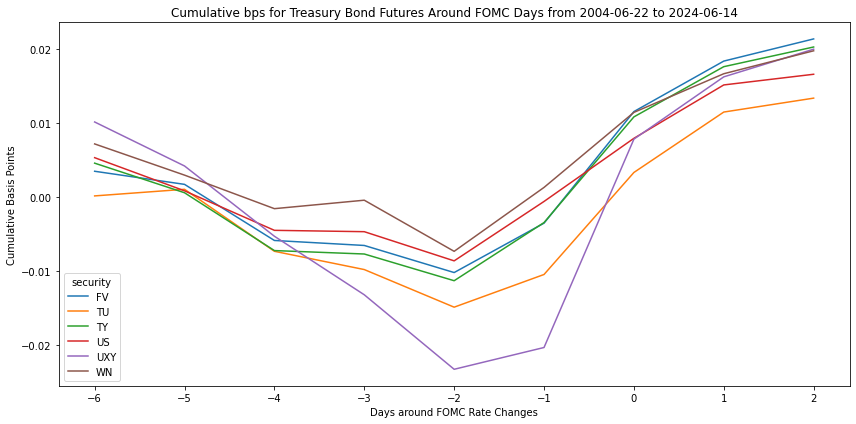

In [6]:
def plot_cumulative_bps(df_cum_bps: pd.DataFrame) -> plt.Figure:
    
    (df_cum_bps.plot(
        figsize = (12,6),
        ylabel = "Cumulative Basis Points",
        xlabel = "Days around FOMC Rate Changes",
        title = "Cumulative bps for Treasury Bond Futures Around FOMC Days from {} to {}".format(
            df_bps_event.date.min(),
            df_bps_event.date.max())))

    plt.tight_layout()
    
plot_cumulative_bps(df_cum_bps)

## Returns conditioned on Fed Event

In [7]:
def _fill_rate_event(df: pd.DataFrame) -> pd.DataFrame: 
    
    vals = df.fed_rate_diff.drop_duplicates().to_list()
    vals.remove(0)
    
    if len(vals) == 0: input_val = 0
    else: input_val = vals[0]
    
    if input_val == 0: event_type = "no_change"
    elif input_val > 0: event_type = "hike"
    else: event_type = "cut"
    
    df_out = (df.assign(
        fed_rate_diff = input_val,
        event = event_type))
    
    return df_out

def get_fed_data(df_bps_event: pd.DataFrame) -> pd.DataFrame: 

    data_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "data", "FedFundsRate.parquet")

    df_fed = (pd.read_parquet(
        path = data_path, engine = "pyarrow").
        sort_values("date").
        rename(columns = {"value": "fed_rate"}).
        drop(columns = ["security"]).
        assign(
            date = lambda x: pd.to_datetime(x.date).dt.date,
            fed_rate_diff = lambda x: x.fed_rate.diff()))

    df_out = (df_bps_event.assign(
        date = lambda x: pd.to_datetime(x.date).dt.date).
        merge(right = df_fed, how = "inner", on = ["date"]).
        groupby("event").
        apply(_fill_rate_event).
        reset_index(drop = True))
    
    return df_out

df_fed_event = get_fed_data(df_bps_event)

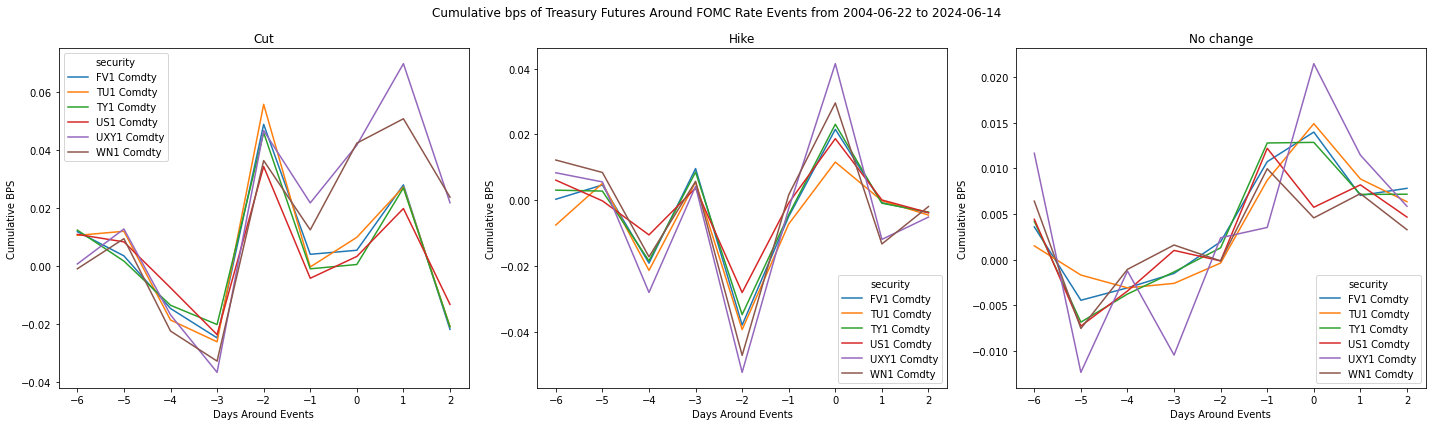

In [8]:
def plot_cumulative_bps(df_fed_event: pd.DataFrame, df_bps_event: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df_fed_event[
        ["day", "bps", "event", "security"]].
        groupby(["day", "security", "event"]).
        agg("mean").
        reset_index().
        assign(event = lambda x: x.event.str.replace("_", " ").str.capitalize()))

    events = df_tmp.event.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(events), figsize = (20,6))

    for event, ax in zip(events, axes.flatten()):

        (df_tmp.query(
            "event == @event").
            drop(columns = ["event"]).
            pivot(index = "day", columns = "security", values = "bps").
            plot(
                ax = ax,
                ylabel = "Cumulative BPS",
                xlabel = "Days Around Events",
                title = event))

    fig.suptitle("Cumulative bps of Treasury Futures Around FOMC Rate Events from {} to {}".format(
        df_bps_event.date.min(),
        df_bps_event.date.max()))

    plt.tight_layout()
    
plot_cumulative_bps(df_fed_event, df_bps_event)

## Returns conditioned on Labor Sentiment

We'll condition returns on the 3rd day before the Fed Hike

In [9]:
def _fill_benlpfed(df: pd.DataFrame) -> pd.DataFrame:
    
    df_out = (df.sort_values(
        "BENLPFED").
        assign(BENLPFED = lambda x: x.BENLPFED.fillna(method = "ffill")))
    
    return df_out

def fill_benlpfed(df_nlp: pd.DataFrame, df_bps_event: pd.DataFrame) -> pd.DataFrame: 

    slice_date = df_nlp.date.min()

    df_bps_tmp = (df_bps_event.assign(
        date = lambda x: pd.to_datetime(x.date).dt.date).
        query("date >= @slice_date"))

    df_out = (df_bps_tmp.query(
        "day == -3")
        [["date"]].
        groupby("date").
        first().
        reset_index().
        merge(right = df_nlp, how = "inner", on = ["date"]).
        merge(right = df_bps_tmp, how = "outer", on = ["date"]).
        groupby("event").
        apply(_fill_benlpfed).
        reset_index(drop = True).
        assign(labor_sentiment = lambda x: np.where(
            x.BENLPFED > 0, 
            "pos", 
            "neg")))
    
    return df_out

df_fill_benlp = fill_benlpfed(df_nlp, df_bps_event)

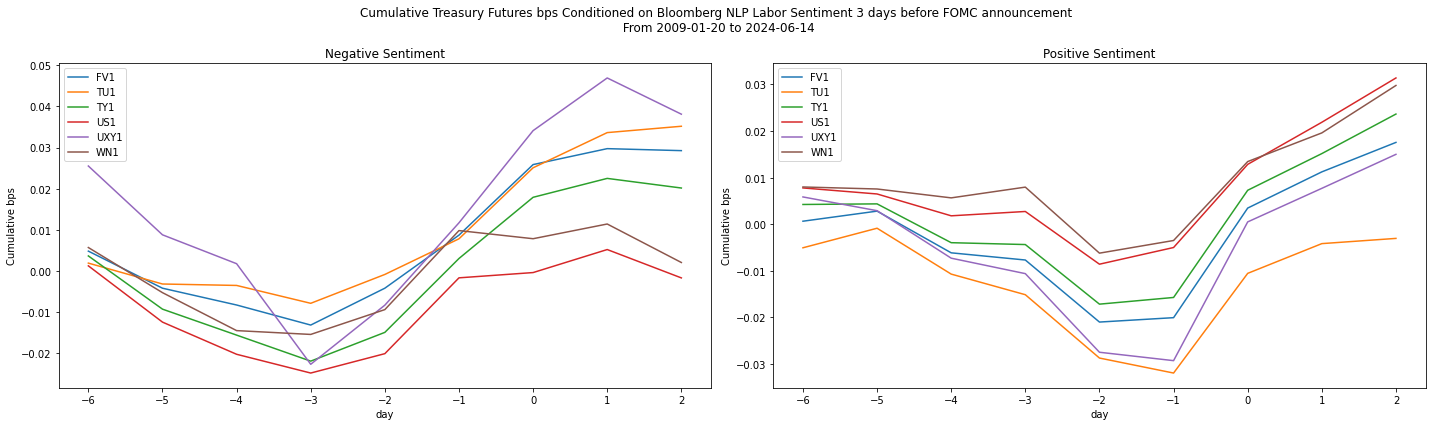

In [10]:
def cumulative_sentiment_bps(df_fill_benlp: pd.DataFrame) -> pd.DataFrame: 
    
    sentiment_dict = {
        "neg": "Negative Sentiment",
        "pos": "Positive Sentiment"}

    fig, axes = plt.subplots(ncols = len(sentiment_dict.keys()), figsize = (20,6))

    df_plot = (df_fill_benlp[
        ["day", "security", "bps", "labor_sentiment"]].
        groupby(["labor_sentiment", "day", "security"]).
        agg("mean").
        reset_index().
        assign(security = lambda x: x.security.str.split(" ").str[0]))

    for sentiment, ax in zip(sentiment_dict.keys(), axes.flatten()):

        (df_plot.query(
            "labor_sentiment == @sentiment").
            drop(columns = ["labor_sentiment"]).
            pivot(index = "day", columns = "security", values = "bps").
            cumsum().
            plot(
                ax = ax,
                ylabel = "Cumulative bps",
                title = sentiment_dict[sentiment]))

        ax.legend(loc = "upper left")

    fig.suptitle("Cumulative Treasury Futures bps Conditioned on Bloomberg NLP Labor Sentiment 3 days before FOMC announcement\n From {} to {}".format(
        df_fill_benlp.date.min(),
        df_fill_benlp.date.max()))
    
    plt.tight_layout()
    
cumulative_sentiment_bps(df_fill_benlp)

## Conditional Returns on Sentiment and Rate Change

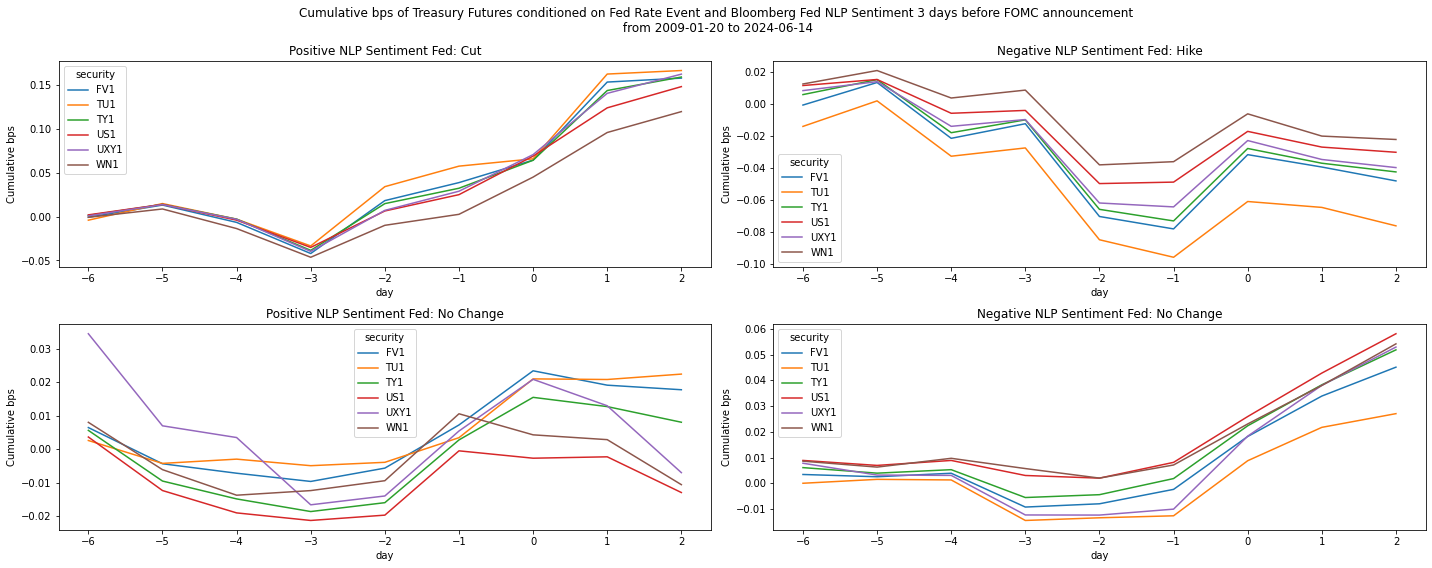

In [11]:
def plot_fed_nlp_conditioned_returns(df_fed_event: pd.DataFrame, df_fill_benlp: pd.DataFrame) -> pd.DataFrame: 

    df_tmp = (df_fed_event[
        ["day", "date", "event"]].
        rename(columns = {"event": "fed_event"}).
        merge(right = df_fill_benlp, how = "inner", on = ["day", "date"]).
        assign(group_var = lambda x: x.fed_event + " " + x.labor_sentiment)
        [["group_var", "day", "security", "bps"]].
        assign(security = lambda x: x.security.str.split(" ").str[0]).
        groupby(["group_var", "day", "security"]).
        agg("mean").
        reset_index())

    events = df_tmp.group_var.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(events) // 2, nrows = len(events) // 2, figsize = (20,8))

    sentiment_renamer = {
        "neg": "Positive NLP Sentiment",
        "pos": "Negative NLP Sentiment"}

    fed_event_renamer = {
        "cut": "Fed: Cut",
        "hike": "Fed: Hike",
        "no_change": "Fed: No Change"}

    for event, ax in zip(events, axes.flatten()):

        fed_event, sentiment = event.split(" ")

        (df_tmp.query(
            "group_var == @event").
            drop(columns = ["group_var"]).
            pivot(index = "day", columns = "security", values = "bps").
            cumsum().
            plot(
                ylabel = "Cumulative bps",
                ax = ax,
                title = sentiment_renamer[sentiment] + " " + fed_event_renamer[fed_event]))

    fig.suptitle("Cumulative bps of Treasury Futures conditioned on Fed Rate Event and Bloomberg Fed NLP Sentiment 3 days before FOMC announcement\n from {} to {}".format(
        df_fill_benlp.date.min(),
        df_fill_benlp.date.max()))

    plt.tight_layout()
    
plot_fed_nlp_conditioned_returns(df_fed_event, df_fill_benlp)

## Buy Treasuries 4 days before and sell them 1 day before FOMC Day

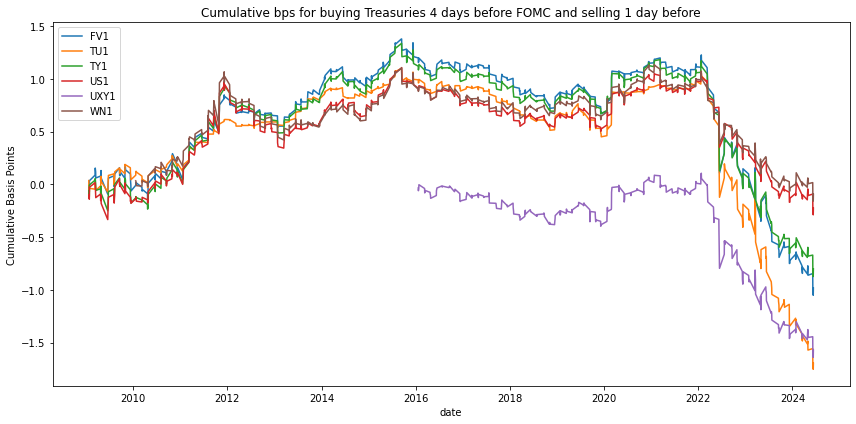

In [12]:
def plot_naive_treasury_returns(df_fill_benlp: pd.DataFrame) -> plt.Figure: 
    
    _, axes = plt.subplots(figsize = (12,6))

    (df_fill_benlp.query(
        "-4 <= day <= -1")
        [["date", "security", "bps"]].
        assign(security = lambda x: x.security.str.split(" ").str[0]).
        drop_duplicates().
        pivot(index = "date", columns = "security", values = "bps").
        cumsum().
        plot(
            ax = axes,
            title = "Cumulative bps for buying Treasuries 4 days before FOMC and selling 1 day before",
            ylabel = "Cumulative Basis Points"))

    axes.legend(loc = "upper left")
    plt.tight_layout()
    
plot_naive_treasury_returns(df_fill_benlp)

The performance has two problems one which is evident and the other which may be more naunced
1. The drop off in performance after 2022 
2. The lack of pre 2009 which only captures one regime of the Fed

The second problem can't be fixed unfortunately. The dropoff of performance comes from the signal being too naive since it always buys Treasuries. Putting aside the lookahead bias first start with conditioning the positioning by using the federal sentiment of 5 days before the fed event for the same window.

In [13]:
def condition_rtn_on_nlp(df_fill_benlp: pd.DataFrame, condition_day = -5, start_trade_date = -4, end_trade_date = -1) -> pd.DataFrame: 
    
    df_pos = (df_fill_benlp.query(
        "day == @condition_day")
        [["event", "labor_sentiment"]])

    df_out = (df_fill_benlp.query(
        "@start_trade_date <= day <= @end_trade_date")
        [["date", "security", "bps", "event"]].
        merge(right = df_pos, how = "inner", on = ["event"]).
        assign(
            security = lambda x: x.security.str.split(" ").str[0],
            signal_bps = lambda x: x.bps * np.where(x.labor_sentiment == "neg", 1, -1))
        [["date", "security", "signal_bps"]])
    
    return df_out

df_conditioned_rtn = condition_rtn_on_nlp(df_fill_benlp)

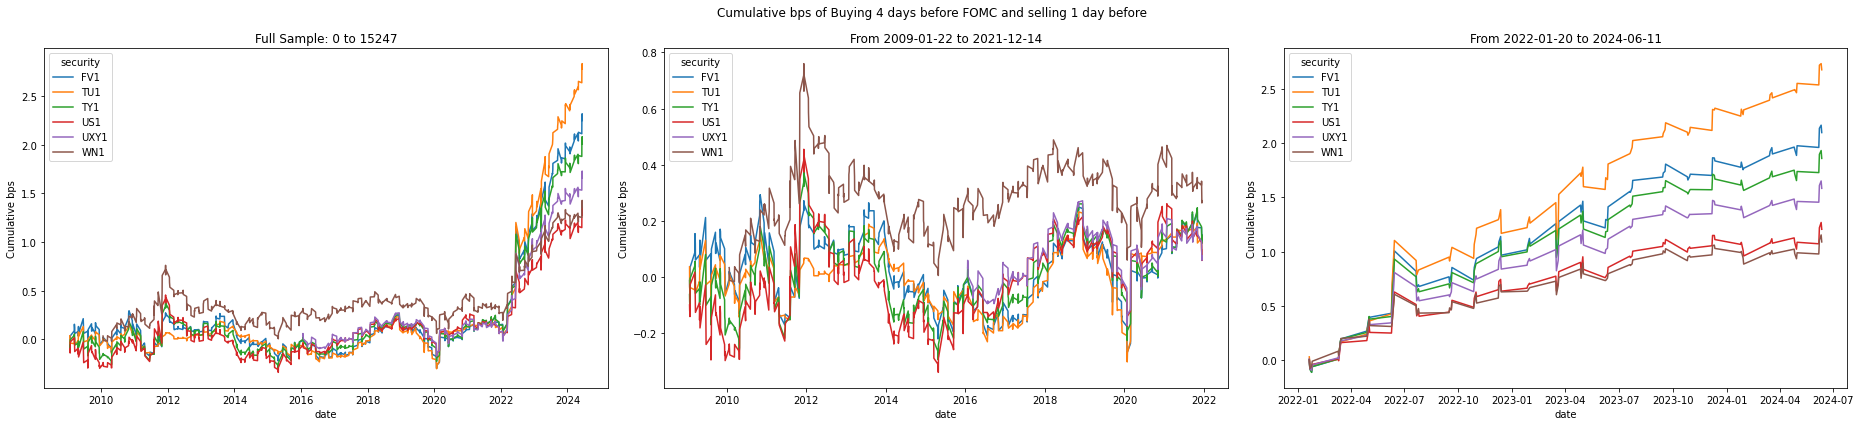

In [14]:
def plot_cumulative_rtn(df_conditioned_rtn: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 3, figsize = (26,6))

    (df_conditioned_rtn.drop_duplicates().pivot(
        index = "date", columns = "security", values = "signal_bps").
        cumsum().
        plot(
            ax = axes[0],
            ylabel = "Cumulative bps",
            title = "Full Sample: {} to {}".format(
                df_conditioned_rtn.index.min(),
                df_conditioned_rtn.index.max())))

    df_pre = (df_conditioned_rtn.drop_duplicates().assign(
        year = lambda x: pd.to_datetime(x.date).dt.year).
        query("year < 2022").
        drop(columns = ["year"]).
        pivot(index = "date", columns = "security", values = "signal_bps").
        cumsum())

    df_post = (df_conditioned_rtn.drop_duplicates().assign(
        year = lambda x: pd.to_datetime(x.date).dt.year).
        query("year >= 2022").
        drop(columns = ["year"]).
        pivot(index = "date", columns = "security", values = "signal_bps").
        cumsum())

    (df_pre.plot(
        ax = axes[1],
        ylabel = "Cumulative bps",
        title = "From {} to {}".format(
            df_pre.index.min(),
            df_pre.index.max())))

    (df_post.plot(
        ax = axes[2],
        ylabel = "Cumulative bps",
        title = "From {} to {}".format(
            df_post.index.min(),
            df_post.index.max())))

    fig.suptitle("Cumulative bps of Buying 4 days before FOMC and selling 1 day before")
    plt.tight_layout()
    
plot_cumulative_rtn(df_conditioned_rtn)

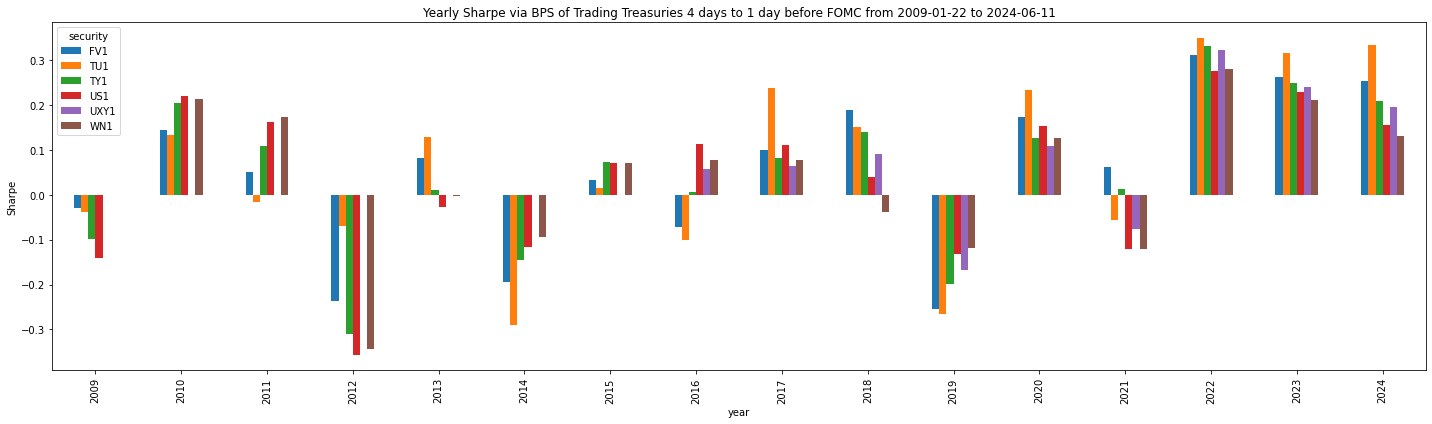

In [15]:
def plot_yearly_sharpe(df_conditioned_rtn: pd.DataFrame) -> plt.Figure: 
    
    (df_conditioned_rtn.assign(
        year = lambda x: pd.to_datetime(x.date).dt.year).
        drop(columns = ["date"]).
        groupby(["year", "security"]).
        agg(["mean", "std"])
        ["signal_bps"].
        rename(columns = {
            "mean": "mean_bps",
            "std": "std_bps"}).
        assign(bps_sharpe = lambda x: x.mean_bps / x.std_bps).
        reset_index()
        [["year", "security", "bps_sharpe"]].
        pivot(index = "year", columns = "security", values = "bps_sharpe").
        plot(
            kind = "bar",
            figsize = (20,6),
            ylabel = "Sharpe",
            title = "Yearly Sharpe via BPS of Trading Treasuries 4 days to 1 day before FOMC from {} to {}".format(
                df_conditioned_rtn.date.min(),
                df_conditioned_rtn.date.max())))
    
    plt.tight_layout()
    
plot_yearly_sharpe(df_conditioned_rtn)

Now check the actual returns rather than using basis points

In [16]:
def _get_rtn(df: pd.DataFrame) -> pd.DataFrame: return(df.sort_values("date").assign(PX_rtn = lambda x: x.PX_LAST.pct_change()))

def get_conditioned_rtn(df_fill_benlp: pd.DataFrame, condition_day = -5, start_trade_date = -4, end_trade_date = - 1) -> pd.DataFrame: 

    df_pos = (df_fill_benlp.query(
        "day == @condition_day")
        [["event", "labor_sentiment"]])

    df_out = (df_fill_benlp.query(
        "@start_trade_date <= day <= @end_trade_date")
        [["date", "security", "event", "PX_LAST"]].
        merge(right = df_pos, how = "inner", on = ["event"]).
        groupby("security").
        apply(_get_rtn).
        reset_index(drop = True).
        assign(
            security = lambda x: x.security.str.split(" ").str[0],
            signal_rtn = lambda x: x.PX_rtn * np.where(x.labor_sentiment == "neg", 1, -1)))
    
    return df_out

df_conditioned_rtn = get_conditioned_rtn(df_fill_benlp)

In [17]:
def _equal_duration(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.assign(
        inverse_duration = lambda x: x.value ** -1,
        total_duration = lambda x: x.inverse_duration.sum(),
        weight = lambda x: x.inverse_duration / x.total_duration,
        duration_exposure = lambda x: x.weight * x.value).
        rename(columns = {"value": "duration"}))
    
    return df_out

def get_equal_duration(df_conditioned_rtn: pd.DataFrame, df_tsy_bps: pd.DataFrame) -> pd.DataFrame:

    df_tmp = (df_conditioned_rtn.drop_duplicates()[
        ["date", "security", "signal_rtn"]].
        groupby(["date", "security"]).
        head(1))

    df_out = (df_tsy_bps.assign(
        security = lambda x: x.security.str.split(" ").str[0])
        [["date", "security", "duration"]].
        pivot(index = "date", columns = "security", values = "duration").
        shift().
        reset_index().
        melt(id_vars = "date").
        dropna().
        assign(date = lambda x: pd.to_datetime(x.date).dt.date).
        merge(right = df_tmp, how = "inner", on = ["date", "security"]).
        dropna().
        groupby("date").
        apply(_equal_duration).
        reset_index(drop = True))
    
    return df_out

df_equal_duration = get_equal_duration(df_conditioned_rtn, df_tsy_bps)

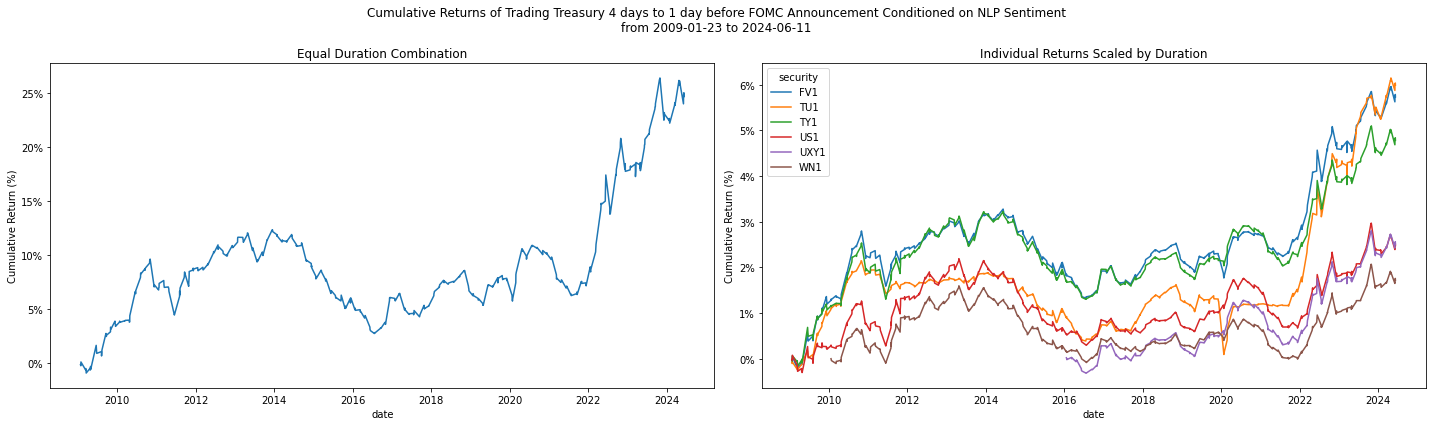

In [18]:
def plot_equal_duration(df_equal_duration: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    df_tmp = (df_equal_duration.assign(
        weight_signal = lambda x: x.weight * x.signal_rtn)
        [["date", "weight_signal"]].
        groupby("date").
        agg("sum").
        rename(columns = {"weight_signal": "Equal Duration"}).
        apply(lambda x: np.cumprod(1 + x) - 1))

    df_ind = (df_equal_duration.assign(
        signal_weight = lambda x: x.weight * x.signal_rtn)
        [["date", "security", "signal_weight"]].
        pivot(index = "date", columns = "security", values = "signal_weight").
        apply(lambda x: np.cumprod(1 + x) - 1))

    df_tmp.plot(
        ax = axes[0],
        legend = False,
        title = "Equal Duration Combination")

    (df_ind.plot(
        ax = axes[1],
        title = "Individual Returns Scaled by Duration"))

    for ax in axes.flatten():

        ax.set_ylabel("Cumulative Return (%)")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
        
    fig.suptitle("Cumulative Returns of Trading Treasury 4 days to 1 day before FOMC Announcement Conditioned on NLP Sentiment\nfrom {} to {}".format(
        df_equal_duration.date.min(),
        df_equal_duration.date.max()))
    
    plt.tight_layout()
    
plot_equal_duration(df_equal_duration)

In [19]:
def get_sharpe(df_equal_duration: pd.DataFrame) -> pd.DataFrame: 

    df_equal_sharpe = (df_equal_duration[
        ["security", "signal_rtn"]].
        groupby("security").
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std": "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]])

    df_port = (df_equal_duration[
        ["date", "signal_rtn"]].
        groupby("date").
        agg("mean").
        agg(["mean", "std"]).
        T.
        rename(columns = {
            "mean": "mean_rtn",
            "std": "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        reset_index().
        replace({"signal_rtn": "Equal\nDuration"}).
        set_index("index"))

    df_out = pd.concat([df_equal_sharpe, df_port])
    return df_out
    
df_sharpe = get_sharpe(df_equal_duration)

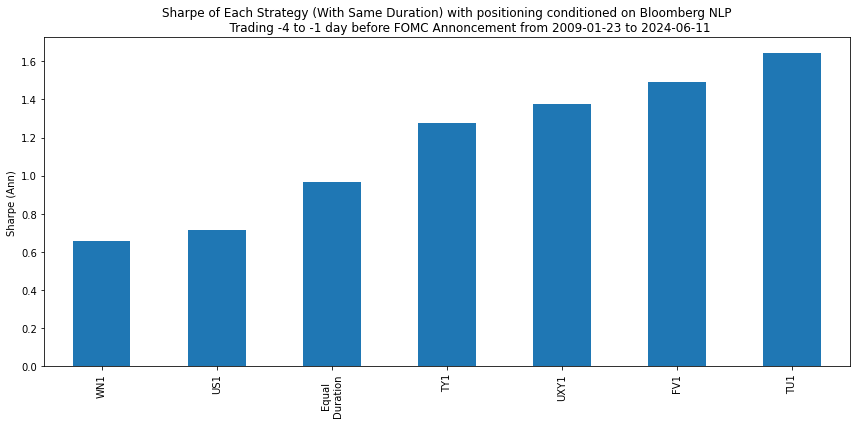

In [20]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    (df_sharpe.sort_values(
        "sharpe").
        plot(
            figsize = (12,6),
            legend = False,
            kind = "bar",
            ylabel = "Sharpe (Ann)",
            title = '''Sharpe of Each Strategy (With Same Duration) with positioning conditioned on Bloomberg NLP
            Trading -4 to -1 day before FOMC Annoncement from {} to {}'''.format(
                df_equal_duration.date.min(),
                df_equal_duration.date.max())))
    
    plt.tight_layout()
    
plot_sharpe(df_sharpe)

The prior backtest conditions signal on the sentiment, the authors condition the entirety of the trade via the sentiment (ie to trade or not to trade). This can be added into the backtest 

In [21]:
def condition_trade(df_nlp: pd.DataFrame, df_bps_event: pd.DataFrame, lookback_window: int = 20) -> pd.DataFrame: 

    df_combined = (df_nlp.sort_values(
        "date").
        assign(
            date = lambda x: pd.to_datetime(x.date).dt.date,
            median_val = lambda x: (x.BENLPFED - x.BENLPFED.rolling(window = lookback_window).median()).shift()).
        dropna().
        merge(right = df_bps_event, how = "inner", on = ["date"]))

    keep_events = (df_combined[
        ["day", "median_val", "event"]].
        drop_duplicates().
        query("day == -5").
        query("median_val > 0").
        event.
        to_list())

    df_keep = df_combined.query("event == @keep_events")

    df_pnl = (df_keep.query(
        "day == -5")
        [["BENLPFED", "event"]].
        drop_duplicates().
        rename(columns = {"BENLPFED": "BENLPFED_pos"}).
        merge(right = df_keep, how = "inner", on = ["event"]).
        assign(pnl = lambda x: x.bps * np.sign(x.BENLPFED_pos)).
        query("day >= -4"))
    
    return df_pnl

df_conditioned_pnl = condition_trade(df_nlp, df_bps_event)

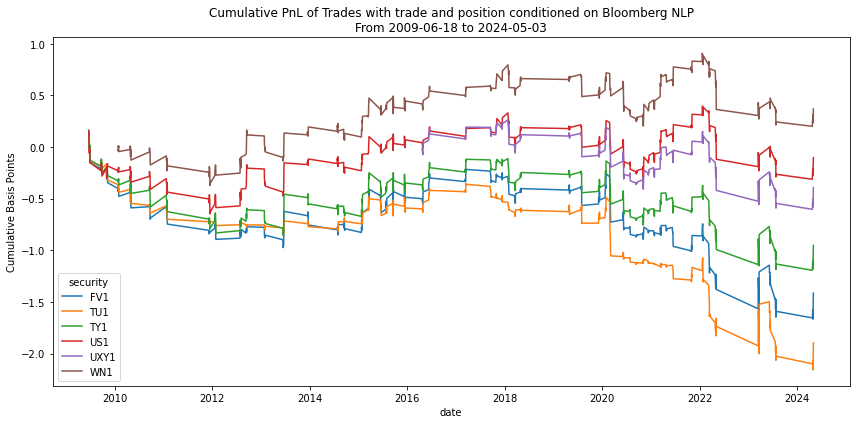

In [22]:
def plot_conditioned_pnl(df_conditioned_pnl: pd.DataFrame) -> plt.Figure: 
    
    (df_conditioned_pnl[
        ["date", "pnl", "security"]].
        assign(security = lambda x: x.security.str.split(" ").str[0]).
        pivot(index = "date", columns = "security", values = "pnl").
        cumsum().
        plot(
            figsize = (12,6),
            ylabel = "Cumulative Basis Points",
            title = "Cumulative PnL of Trades with trade and position conditioned on Bloomberg NLP\nFrom {} to {}".format(
                df_conditioned_pnl.date.min(),
                df_conditioned_pnl.date.max())))

    plt.tight_layout()
    
plot_conditioned_pnl(df_conditioned_pnl)

The underperformance is quite noticable, while there isn't empirical evidence to directly contradict what the authors proposed the problem like stems from how the Bloomberg NLP data is generated. 

In [23]:
def run_wilcoxon_test(df_nlp: pd.DataFrame, significant_value: float = 0.05) -> None:

    median_diffs = (df_nlp.sort_values(
        "date").
        assign(median_diff = lambda x: x.BENLPFED - x.BENLPFED.rolling(window = 10).median()).
        median_diff.
        dropna())

    stat, p_value = stats.wilcoxon(median_diffs)

    if p_value < significant_value: print("P-Value: {} Reject Null Hypothesis the medians are statistically significant".format(round(p_value, 2)))
    else: print("P-Value: {} Accept Null Hypothesis the medians aren't statistically significant".format(round(p_value, 2)))
    
run_wilcoxon_test(df_nlp)

P-Value: 0.95 Accept Null Hypothesis the medians aren't statistically significant
